# Slice/Sliver Analysis based on various filters

This notebook provides an interactive tool to analyze **resource usage** (e.g., SmartNICs, GPUs, FPGAs, Storage) and **slice activity** across the FABRIC testbed.

## Purpose

- Identify the **Top 10 users** based on the number of component-based slivers used within a selected time range.
- Analyze and filter **slices** based on metadata such as state, site, component type, and time window.
- Allow dynamic filtering by:
  - Component type (e.g., SmartNIC, GPU)
  - Component model (e.g., ConnectX-6)
  - Sliver type (e.g., VM, FABNetv4)
  - Slice state (e.g., StableOK, Closing, Dead)
  - Site (include/exclude)
- Enable exporting and visualizing results.

## How it works

### Sliver Analysis
- Slivers are queried from the FABRIC API based on user-specified filters.
- Filters can include component metadata and sliver characteristics.
- Only slivers associated with hardware components are considered.
- The results are grouped by user to identify the **top consumers** of testbed resources.

### Slice Analysis
- Slices are retrieved using interactive time and state filters.
- Filtering supports inclusion/exclusion of specific slice states (e.g., exclude `Dead`, `Closing`).
- Additional filters for component type, component model, and sites may be applied.
- The output enables insight into **slice allocation patterns** and **user engagement** over time.

Use the interactive widgets provided in each section below to customize and execute your queries.


This cell contains part of the data processing or sliver query logic used to filter and rank users by component usage.

In [1]:
from fabric_reports_client.reports_api import ReportsApi
from datetime import datetime, timezone
import json
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

#api =  ReportsApi(base_url="https://reports.fabric-testbed.net/reports", token_file="/Users/kthare10/work/id_token_prod.json")
api =  ReportsApi(base_url="https://alpha-5.fabric-testbed.net/reports", token_file="/Users/kthare10/work/id_token_alpha.json")

query_start=None

query_end = datetime.now(timezone.utc)
query_end = query_end.isoformat(timespec='milliseconds')

fabric_projects = ['2dd1ffb8-1aff-45cc-a70d-eb93b65cc26b', '4604cab7-41ff-4c1a-a935-0ca6f20cceeb', '6b76128d-c73f-431f-a245-0397586a7d40', '32e7160e-0318-43f5-a4e3-80209f880833', 
                   '75835e68-f91f-474d-8d54-27a576cc252f', '990d8a8b-7e50-4d13-a3be-0f133ffa8653', '04b14c17-e66a-4405-98fc-d737717e2160', '1630021f-0a0c-4792-a241-997f410d36e1', 
                   '7a5adb91-c4c0-4a1c-8021-7b6c56af196f', '06e8d02a-b27f-4437-829e-8378d20e5a08', '7f33ecf0-5dd7-4fd5-b1b7-061367f8bca6']

## Query all Slices

In [2]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime
from pytz import UTC

# === Global DataFrame for reuse ===
df_slices = pd.DataFrame()

# === Default start: June 1, 2023 | Default end: Start of current month ===
default_start = datetime(2023, 6, 1, tzinfo=UTC)
default_end = datetime.now(UTC).replace(day=1, hour=0, minute=0, second=0, microsecond=0)

# === Widgets ===
slice_start_picker = widgets.DatetimePicker(description='Slice Start:', value=default_start)
slice_end_picker = widgets.DatetimePicker(description='Slice End:', value=default_end)
slice_run_button = widgets.Button(description="Query Slices")
slice_status_output = widgets.Output()

# === Display UI ===
display(slice_start_picker, slice_end_picker, slice_run_button, slice_status_output)

# === Callback ===
def run_slice_query(b):
    global df_slices
    slice_status_output.clear_output()

    start_time = slice_start_picker.value
    end_time = slice_end_picker.value

    if not start_time or not end_time or start_time >= end_time:
        with slice_status_output:
            print("⚠️ Please ensure start time is before end time.")
        return

    slice_run_button.disabled = True
    with slice_status_output:
        print(f"⏳ Querying slices from {start_time} to {end_time}...")

    try:
        response = api.query_slices(
            start_time=start_time,
            end_time=end_time,
            fetch_all=True,
            per_page=1000,
            exclude_project_id=fabric_projects
        )

        slices = response.get("data", [])
        df_slices = pd.DataFrame(slices)

        slice_status_output.clear_output()
        with slice_status_output:
            print(f"✅ Query complete. Total slices: {response.get('total', len(df_slices))}")

        if not df_slices.empty:
            display(df_slices)
        else:
            with slice_status_output:
                print("No slices returned.")

    except Exception as e:
        with slice_status_output:
            print(f"❌ Error during query: {e}")

    slice_run_button.disabled = False

# === Bind button click ===
slice_run_button.on_click(run_slice_query)


DatetimePicker(value=datetime.datetime(2023, 6, 1, 0, 0, tzinfo=<UTC>), description='Slice Start:')

DatetimePicker(value=datetime.datetime(2025, 5, 1, 0, 0, tzinfo=<UTC>), description='Slice End:')

Button(description='Query Slices', style=ButtonStyle())

Output()

,lease_end,lease_start,project_id,project_name,slice_id,slice_name,slivers,state,user_email,user_id
0,2025-08-14T20:52:03+00:00,2025-02-13T20:52:04.761000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,a22cb30b-5752-44ee-aa3c-04ce8b3a7641,ei-network-20250213154956,{'total': 15},StableOK,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
1,2025-08-11T18:31:47+00:00,2025-02-10T18:31:47.845000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,4c5e1c0d-893c-4eb8-8e9f-09f1702707ec,monitor,{'total': 3},StableOK,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
2,2025-08-11T16:49:37+00:00,2025-02-10T16:49:39.163000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,714b71f2-0af8-40a5-a669-25d79d09e9d5,prod,{'total': 15},Dead,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
3,2025-07-18T16:43:23+00:00,2025-01-17T16:43:24.411000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,5e0688be-0015-4d8e-9536-25ac1c9a514a,ei-network-20250117114154,{'total': 15},Dead,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
4,2025-07-18T16:26:03+00:00,2025-01-17T16:26:04.302000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,25f0c674-78a1-435b-b086-400353c9b1e3,ei-network-20250117112415,{'total': 15},Dead,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
...,...,...,...,...,...,...,...,...,...,...
40595,2024-08-17T19:33:21+00:00,2024-08-16T19:33:21+00:00,abe55161-26d9-434a-826a-4f9a655d0dde,Patchwork: Testbed-wide Traffic Profiling for ...,bb240d15-90c2-47e8-aeaf-6533cd718d0b,NaN,{'total': 44},Dead,nshyamkumar@iit.edu,bc1ce1df-bf7e-43e9-881e-5f10fa5c7221
40596,2024-11-13T19:41:03+00:00,2024-11-12T19:41:03+00:00,f1f5b0f8-0eef-40f3-940e-c4c8ff2d60ca,High Performance Routing Dataplanes Performanc...,16effb8a-4ca0-4078-aada-396ffa9323e1,NaN,{'total': 6},Dead,marcos.schwarz@rnp.br,17fe0c48-110c-4e80-8d9d-b96f318bd2f7
40597,2025-04-29T16:31:45.533000+00:00,2025-04-28T16:31:54.534000+00:00,34a45f8f-be0e-4efc-a91c-38358ce4ca29,Ensemble Inference,d022b785-81b8-4a9b-9830-3aa103b43cc7,byteps_8node_A30,{'total': 28},Closing,yuanjun.dai@case.edu,82e78849-be30-4290-a225-50040c065e4e
40598,2025-04-29T16:08:44.533000+00:00,2025-04-28T16:08:46.534000+00:00,34a45f8f-be0e-4efc-a91c-38358ce4ca29,Ensemble Inference,6a14de85-2889-4ab7-874f-368ffc80f959,byteps_8node_A30,{'total': 28},Closing,yuanjun.dai@case.edu,82e78849-be30-4290-a225-50040c065e4e


## Slices by User Email
Uses `df_slices` dataframe produced by the avove query.

In [3]:
# Step 3: Interactive selection and filtering
def create_user_selector(df):
    user_emails = sorted(df['user_email'].dropna().unique())
    dropdown = widgets.Dropdown(options=user_emails, description="User Email:")
    
    def on_select_user(change):
        selected_user = change['new']
        user_slices = df[df['user_email'] == selected_user]
        display(user_slices[['user_email', 'user_id', 'slice_name', 'slice_id', 'lease_start', 'lease_end']].sort_values(by='lease_start'))

    dropdown.observe(on_select_user, names='value')
    display(dropdown)

# Run everything
create_user_selector(df_slices)

Dropdown(description='User Email:', options=('AAT38@pitt.edu', 'ABK171@pitt.edu', 'AIB79@pitt.edu', 'AKM88@pit…

,user_email,user_id,slice_name,slice_id,lease_start,lease_end
7042,ATS29@email.sc.edu,ae351d5a-0a3e-445a-a5a5-d93e624c5194,NaN,a3916602-72e2-4d41-aff6-cf2c75d5ea0e,2024-10-14 18:25:33+00:00,2024-10-14 18:37:13+00:00
33292,ATS29@email.sc.edu,ae351d5a-0a3e-445a-a5a5-d93e624c5194,NaN,d4d18957-e57b-4aeb-b8bf-e5ec8334039d,2024-10-24 14:11:11+00:00,2024-10-25 14:11:05+00:00
36135,ATS29@email.sc.edu,ae351d5a-0a3e-445a-a5a5-d93e624c5194,NaN,2bab8447-3766-4b72-afe3-4e217f5da5bf,2024-11-06 21:06:37+00:00,2024-11-07 21:06:37+00:00
36138,ATS29@email.sc.edu,ae351d5a-0a3e-445a-a5a5-d93e624c5194,NaN,01e165a6-d0b8-4d5f-8d5b-a74daf87de17,2024-11-06 21:28:38+00:00,2024-11-07 21:28:38+00:00
36139,ATS29@email.sc.edu,ae351d5a-0a3e-445a-a5a5-d93e624c5194,NaN,7060c7d9-d372-4aa5-b489-414a1029bbf0,2024-11-06 21:33:48+00:00,2024-11-07 21:33:48+00:00
36149,ATS29@email.sc.edu,ae351d5a-0a3e-445a-a5a5-d93e624c5194,NaN,7bc4d5d9-c1ae-4e0e-be80-97fffa71438b,2024-11-06 21:36:08+00:00,2024-11-07 21:36:08+00:00
36150,ATS29@email.sc.edu,ae351d5a-0a3e-445a-a5a5-d93e624c5194,NaN,f8d3e15e-227a-4800-bb9a-1edcf5740794,2024-11-06 21:45:08+00:00,2024-11-07 21:45:08+00:00
36441,ATS29@email.sc.edu,ae351d5a-0a3e-445a-a5a5-d93e624c5194,NaN,69452e6b-6996-489c-949e-611d86277dba,2024-11-10 18:04:16+00:00,2024-11-11 18:04:16+00:00
36668,ATS29@email.sc.edu,ae351d5a-0a3e-445a-a5a5-d93e624c5194,NaN,d36de6f6-abba-45ca-8499-167a21d22d4e,2024-11-13 01:32:00+00:00,2024-11-14 01:32:00+00:00
36767,ATS29@email.sc.edu,ae351d5a-0a3e-445a-a5a5-d93e624c5194,NaN,317f73a5-2ce3-4798-aa2d-4fbfc94e22d7,2024-11-14 02:44:14+00:00,2024-11-15 02:44:14+00:00


## Slices per Month

`df_slices` produced by previous cell is used to plot these slices.

/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_12318/3031504529.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['lease_start'].dt.to_period('M')  # '2025-04'


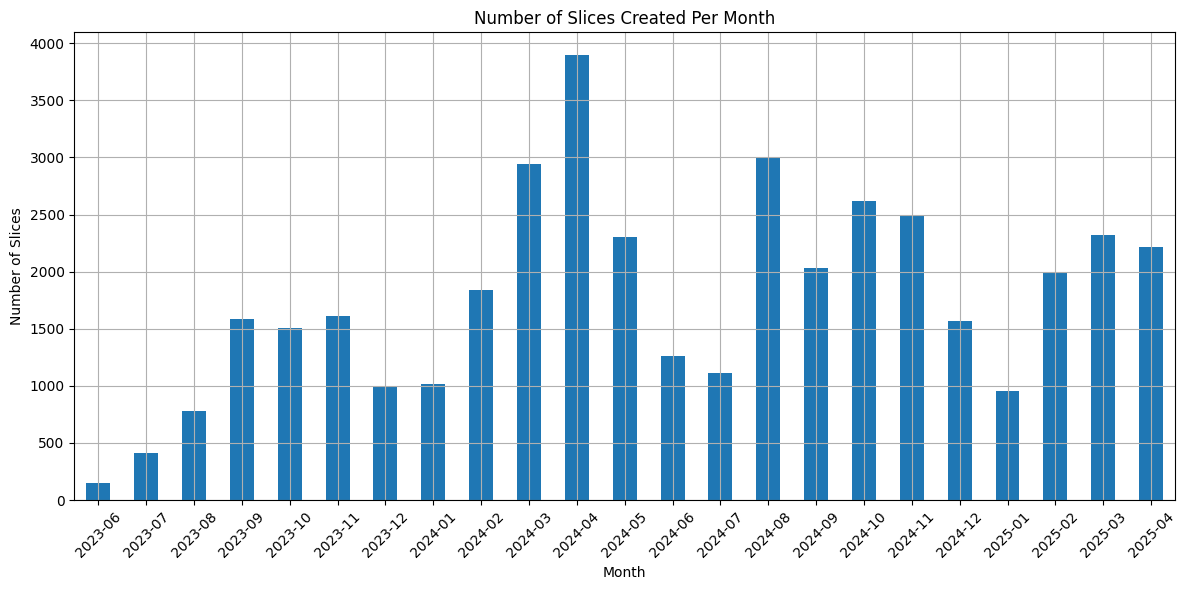

In [4]:

# Step 3: Create DataFrame and process dates
df = df_slices

df['lease_start'] = pd.to_datetime(df['lease_start'], format="mixed", utc=True)
df['month'] = df['lease_start'].dt.to_period('M')  # '2025-04'

monthly_counts = df.groupby('month').size().sort_index()
#for month, count in monthly_counts.items():
#    print(f"{month}: {count}")

# Step 6: Plot
monthly_counts.plot(kind='bar', figsize=(12, 6))
plt.title('Number of Slices Created Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Slices')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Active Slices per Month

`df_slices` dataframe from the query above is used here too.

/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_12318/547082105.py:7: UserWarning: Converting to Period representation will drop timezone information.
  start_month = df['lease_start'].min().to_period('M').to_timestamp()
/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_12318/547082105.py:8: UserWarning: Converting to Period representation will drop timezone information.
  end_month = df['lease_end'].max().to_period('M').to_timestamp()


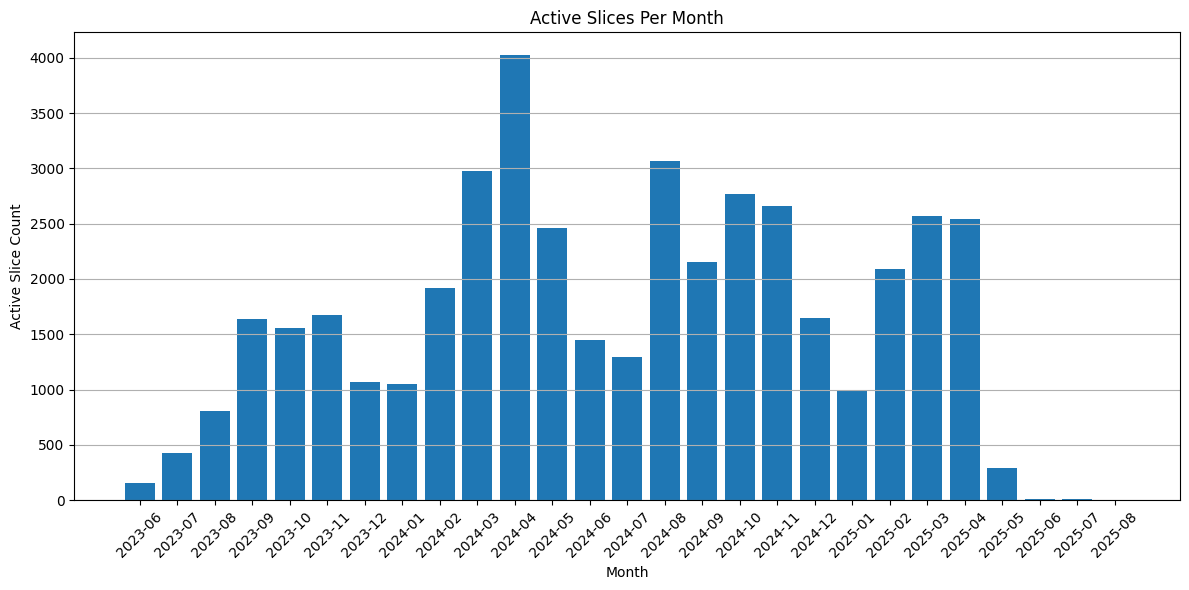

In [5]:
df = df_slices
# Robust datetime parsing using 'mixed' format
df['lease_start'] = pd.to_datetime(df['lease_start'], format="mixed", utc=True)
df['lease_end'] = pd.to_datetime(df['lease_end'], format="mixed", utc=True)

# Generate monthly range
start_month = df['lease_start'].min().to_period('M').to_timestamp()
end_month = df['lease_end'].max().to_period('M').to_timestamp()
month_range = pd.date_range(start=start_month, end=end_month, freq='MS')

# Count active slices per month
active_counts = []
for month_start in month_range:
    month_start = month_start.tz_localize("UTC")
    month_end = (month_start + relativedelta(months=1)) - pd.Timedelta(seconds=1)
    active = df[(df['lease_start'] <= month_end) & (df['lease_end'] >= month_start)]
    active_counts.append(len(active))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(month_range.strftime('%Y-%m'), active_counts)
plt.xticks(rotation=45)
plt.title("Active Slices Per Month")
plt.xlabel("Month")
plt.ylabel("Active Slice Count")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


## Query Slices filtered by Component Types/Component Model

In [6]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime
from pytz import UTC

# === Global DataFrame ===
df_slices_by_component = pd.DataFrame()
components_selected = []

# === Default time window ===
default_start = datetime(2023, 6, 1, tzinfo=UTC)
default_end = datetime.now(UTC).replace(day=1, hour=0, minute=0, second=0, microsecond=0)

# === Widgets ===
slice_start_picker = widgets.DatetimePicker(description='Slice Start:', value=default_start)
slice_end_picker = widgets.DatetimePicker(description='Slice End:', value=default_end)

component_type_select = widgets.SelectMultiple(
    options=["GPU", "SmartNIC", "SharedNIC", "FPGA", "NVME", "Storage"],
    description="Component Type:"
)

component_model_text = widgets.Text(
    description="Component Model(s):",
    placeholder="comma-separated, e.g. ConnectX-6, A100"
)

site_include_text = widgets.Text(description="Include Sites:", placeholder="comma-separated")
site_exclude_text = widgets.Text(description="Exclude Sites:", placeholder="comma-separated")

slice_run_button = widgets.Button(description="Query Slices")
slice_status_output = widgets.Output()

# === Display all widgets ===
display(
    slice_start_picker, slice_end_picker,
    component_type_select, component_model_text,
    site_include_text, site_exclude_text,
    slice_run_button, slice_status_output
)

# === Callback ===
def run_slice_query(b):
    global df_slices_by_component
    global components_selected
    slice_status_output.clear_output()

    start_time = slice_start_picker.value
    end_time = slice_end_picker.value

    if not start_time or not end_time or start_time >= end_time:
        with slice_status_output:
            print("⚠️ Please ensure start time is before end time.")
        return

    # Parse selected filters
    component_types = list(component_type_select.value)
    components_selected = component_types
    component_models = [m.strip() for m in component_model_text.value.split(",") if m.strip()]
    include_sites = [s.strip() for s in site_include_text.value.split(",") if s.strip()]
    exclude_sites = [s.strip() for s in site_exclude_text.value.split(",") if s.strip()]

    # Build query params
    query_params = {
        "start_time": start_time,
        "end_time": end_time,
        "fetch_all": True,
        "per_page": 1000,
        "exclude_project_id": fabric_projects
    }

    if component_types:
        query_params["component_type"] = component_types
    if component_models:
        query_params["component_model"] = component_models
    if include_sites:
        query_params["site_name"] = include_sites
    if exclude_sites:
        query_params["exclude_site_name"] = exclude_sites

    slice_run_button.disabled = True
    with slice_status_output:
        print("⏳ Querying slices with filters:")
        print(f"   Time range: {start_time} → {end_time}")
        if component_types: print(f"   Component Types: {component_types}")
        if component_models: print(f"   Component Models: {component_models}")
        if include_sites: print(f"   Include Sites: {include_sites}")
        if exclude_sites: print(f"   Exclude Sites: {exclude_sites}")

    try:
        response = api.query_slices(**query_params)
        df_slices_by_component = pd.DataFrame(response.get("data", []))

        slice_status_output.clear_output()
        with slice_status_output:
            print(f"✅ Query complete. Total slices: {response.get('total', len(df_slices_by_component))}")

        if not df_slices_by_component.empty:
            display(df_slices_by_component)
        else:
            with slice_status_output:
                print("No slices returned.")

    except Exception as e:
        with slice_status_output:
            print(f"❌ Error during query: {e}")

    slice_run_button.disabled = False

# === Bind button click ===
slice_run_button.on_click(run_slice_query)


DatetimePicker(value=datetime.datetime(2023, 6, 1, 0, 0, tzinfo=<UTC>), description='Slice Start:')

DatetimePicker(value=datetime.datetime(2025, 5, 1, 0, 0, tzinfo=<UTC>), description='Slice End:')

SelectMultiple(description='Component Type:', options=('GPU', 'SmartNIC', 'SharedNIC', 'FPGA', 'NVME', 'Storag…

Text(value='', description='Component Model(s):', placeholder='comma-separated, e.g. ConnectX-6, A100')

Text(value='', description='Include Sites:', placeholder='comma-separated')

Text(value='', description='Exclude Sites:', placeholder='comma-separated')

Button(description='Query Slices', style=ButtonStyle())

Output()

,lease_end,lease_start,project_id,project_name,slice_id,slivers,state,user_email,user_id,slice_name
0,2024-04-26T17:14:54+00:00,2024-04-26T17:09:19+00:00,68926660-da26-475d-9c40-50ebf0a5a812,GAF,622cfde1-7354-4465-a73c-0e07eff47d3d,{'total': 3},Dead,vovwm@missouri.edu,47558890-b6a9-4311-9a76-24849cc43dd2,NaN
1,2023-12-31T04:50:27+00:00,2023-12-31T04:21:50+00:00,a6504676-441c-4d76-ab04-5b13212df83d,AI in life sciences,fe1006f9-5e5c-41bf-873a-3058d389f962,{'total': 1},Dead,madas@siue.edu,e83f3dc7-ce7d-4ef5-a404-1a268791d256,NaN
2,2024-11-09T03:15:43+00:00,2024-11-03T20:23:31+00:00,6ce270de-788d-4e07-8bae-3206860a6387,NaN,d2100204-baba-4b2e-998c-2b404694da70,{'total': 1},Dead,nchapre@asu.edu,cd66ed0e-f5a2-4e94-9aa9-358700eeafc7,NaN
3,2023-09-27T10:48:32+00:00,2023-09-27T03:41:18+00:00,7bc05490-ba40-45ba-99dc-b011680825d2,FABRIC Clemson,3f4bc5f5-90f9-444e-a90d-5981de1f0466,{'total': 8},Dead,aacheme@clemson.edu,bb12773f-5b20-458b-af12-7fa3dbafb5ee,NaN
4,2023-12-15T23:36:44+00:00,2023-12-15T23:12:25+00:00,a6504676-441c-4d76-ab04-5b13212df83d,AI in life sciences,a73aa698-fdc2-4da0-90b9-a873968dae36,{'total': 1},Dead,madas@siue.edu,e83f3dc7-ce7d-4ef5-a404-1a268791d256,NaN
...,...,...,...,...,...,...,...,...,...,...
2388,2024-11-19T13:05:50+00:00,2024-11-18T13:05:50+00:00,7bc05490-ba40-45ba-99dc-b011680825d2,FABRIC Clemson,5e8d0633-1c9c-48ad-a7bc-0caad656ce10,{'total': 4},Dead,vchemph@clemson.edu,00edb446-9301-4d29-84ca-a29abebd8161,NaN
2389,2024-04-26T16:28:33+00:00,2024-04-26T16:28:23+00:00,68926660-da26-475d-9c40-50ebf0a5a812,GAF,31b6c641-4f84-46df-8e5f-946dba72539d,{'total': 1},Dead,praveen.rao@missouri.edu,9213b748-d6e5-4daf-9758-525629679049,NaN
2390,2024-12-10T16:35:30+00:00,2024-12-09T16:35:30+00:00,1ecd9d6a-7701-40fa-b78e-b2293c9526ed,AtlanticWave-SDX,1dde9101-e635-4372-a42d-41715c20d76d,{'total': 2},Dead,absahin@fiu.edu,34d145a9-be4c-4385-8eb6-a9af4d335eef,NaN
2391,2023-12-07T18:28:13+00:00,2023-12-06T22:01:29+00:00,68926660-da26-475d-9c40-50ebf0a5a812,GAF,9b7ef11f-df64-4a28-943d-4efdef7ad753,{'total': 5},Dead,c.webb@mail.missouri.edu,8b1a931e-abb3-4371-a6e2-dcb82257bdc9,NaN


,lease_end,lease_start,project_id,project_name,slice_id,slice_name,slivers,state,user_email,user_id
0,2025-03-18T13:43:43+00:00,2025-03-05T13:22:51+00:00,3938caa6-d523-46bf-8525-a94f7efab181,2024 Bachelor Graduation Project Wouter P.,5b85116b-0f75-4d8f-bc6b-9d8ad6ded263,OFC demo topology,{'total': 8},Dead,anestisdalgkitsis@gmail.com,5d99bce9-8c7b-4185-93df-da5b1f95cd40
1,2025-03-18T02:03:14+00:00,2025-03-04T22:03:55+00:00,bbe0d94c-736b-477a-a2e6-fef9fe7ac9ca,EJFAT,6fd3fc49-4410-4b7c-b841-1db4e2722490,E2SAR U280 LB Slice on LOSA,{'total': 4},Dead,baldin@jlab.org,b7fb5be6-9048-43ad-b495-d214fc5af8ba
2,2025-03-23T16:12:36+00:00,2025-02-21T10:23:35+00:00,3938caa6-d523-46bf-8525-a94f7efab181,2024 Bachelor Graduation Project Wouter P.,829fca07-4b7f-4de2-9404-c62a23a7ec4e,INT slice - CLEM + KANS,{'total': 7},Dead,s317694@studenti.polito.it,d471d095-eb3a-4ba0-9864-e11201b7de54
3,2025-03-13T09:01:42+00:00,2025-02-28T08:46:26+00:00,3938caa6-d523-46bf-8525-a94f7efab181,2024 Bachelor Graduation Project Wouter P.,732d48a5-a9f9-4e4c-b6bc-b0bb86aea581,OFC demo topology,{'total': 8},Dead,s317694@studenti.polito.it,d471d095-eb3a-4ba0-9864-e11201b7de54
4,2025-03-07T15:00:18+00:00,2025-02-21T15:00:18+00:00,bbe0d94c-736b-477a-a2e6-fef9fe7ac9ca,EJFAT,f4a0206d-c2bb-496f-89d8-98defd4e9f89,E2SAR U280 LB Slice on LOSA,{'total': 2},Dead,baldin@jlab.org,b7fb5be6-9048-43ad-b495-d214fc5af8ba
...,...,...,...,...,...,...,...,...,...,...
1546,2025-01-28T05:02:48+00:00,2025-01-27T05:02:48+00:00,bbe0d94c-736b-477a-a2e6-fef9fe7ac9ca,EJFAT,33f513db-a9ca-44ed-9e29-d530f5b05a53,NaN,{'total': 2},Dead,tsai@jlab.org,e42af1dd-7030-44c7-96a1-6be5324aa8eb
1547,2025-01-30T20:12:14+00:00,2025-01-29T20:12:14+00:00,f8791874-1b0a-49bf-bc4d-7142be017468,FPGA-based Programmable Networking,83402b5b-3c23-44cf-8c1e-2a8e57108b2b,NaN,{'total': 5},Dead,nshyamkumar@iit.edu,bc1ce1df-bf7e-43e9-881e-5f10fa5c7221
1548,2024-03-06T03:31:49+00:00,2024-03-05T03:31:49+00:00,a93b8d1a-a9dd-480d-b1f1-23c3889a7e17,NaN,71d43b59-7c3e-4607-a2ad-4b5d8ace2c32,NaN,{'total': 38},Dead,hbang3@hawk.iit.edu,7baac318-48b4-43b3-bc3e-ac3dfd23d7bc
1549,2024-03-09T19:27:38+00:00,2024-03-08T19:27:38+00:00,a93b8d1a-a9dd-480d-b1f1-23c3889a7e17,NaN,b6fdd9d7-d978-45d0-85d4-55f4492db7d4,NaN,{'total': 15},Dead,nsultana1@iit.edu,83b7a00c-fd23-43e7-82fa-af68411d270f


## Active Slices containing specific components
`df_slices_by_component` dataframe generated by the above query is used.
`components_selected` specifies the chose component types.

/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_12318/504596361.py:9: UserWarning: Converting to Period representation will drop timezone information.
  start_month = df['lease_start'].min().to_period('M').to_timestamp()
/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_12318/504596361.py:10: UserWarning: Converting to Period representation will drop timezone information.
  end_month = df['lease_end'].max().to_period('M').to_timestamp()


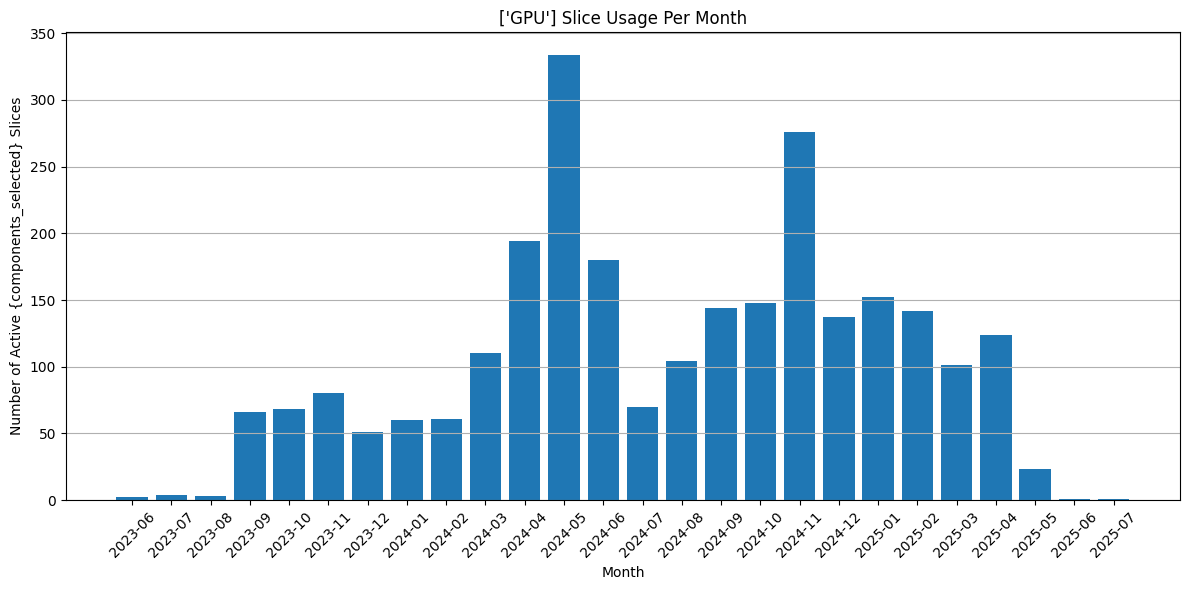

In [7]:
df = df_slices_by_component

# Step 2: Convert lease_start and lease_end to datetime (with UTC awareness)
# Robust datetime parsing using 'mixed' format
df['lease_start'] = pd.to_datetime(df['lease_start'], utc=True, format='mixed')
df['lease_end'] = pd.to_datetime(df['lease_end'], utc=True, format='mixed')

# Step 3: Define the month range for plotting
start_month = df['lease_start'].min().to_period('M').to_timestamp()
end_month = df['lease_end'].max().to_period('M').to_timestamp()
month_range = pd.date_range(start=start_month, end=end_month, freq='MS')

# Step 4: Count SmartNIC slices active in each month
smartnic_counts = []

for month_start in month_range:
    month_start = month_start.tz_localize("UTC")
    month_end = (month_start + relativedelta(months=1)) - pd.Timedelta(seconds=1)

    active_slices = df[
        (df['lease_start'] <= month_end) &
        (df['lease_end'] >= month_start)
    ]
    smartnic_counts.append(len(active_slices))

# Step 5: Plot the results
plt.figure(figsize=(12, 6))
plt.bar(month_range.strftime('%Y-%m'), smartnic_counts)
plt.xticks(rotation=45)
plt.title(f"{components_selected} Slice Usage Per Month")
plt.xlabel("Month")
plt.ylabel("Number of Active {components_selected} Slices")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


## Query current Active Slices

Generates `df_slices_state` dataframe containing slices filtered by Slice State which can be used for any plotting. 

In [8]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime
from pytz import UTC

# === Global DataFrame ===
df_slices_state = pd.DataFrame()

# === Possible slice states ===
SLICE_STATES = [
    "Nascent", "Configuring", "StableError", "StableOK",
    "Closing", "Dead", "Modifying", "ModifyOK", "ModifyError",
    "AllocatedError", "AllocatedOK"
]

# === Default state filters ===
default_exclude_states = ["Closing", "Dead"]

# === Widgets ===
state_include_picker = widgets.SelectMultiple(
    options=SLICE_STATES,
    description="Include States:",
    rows=len(SLICE_STATES),
)

state_exclude_picker = widgets.SelectMultiple(
    options=SLICE_STATES,
    value=tuple(default_exclude_states),
    description="Exclude States:",
    rows=len(SLICE_STATES),
)

state_run_button = widgets.Button(description="Query Slices by State")
state_status_output = widgets.Output()

display(state_include_picker, state_exclude_picker, state_run_button, state_status_output)

# === Callback ===
def run_slice_state_query(b):
    global df_slices_state
    state_status_output.clear_output()

    include_states = list(state_include_picker.value)
    exclude_states = list(state_exclude_picker.value)

    query_params = {
        "fetch_all": True,
        "per_page": 1000,
        "exclude_project_id": fabric_projects
    }

    if include_states:
        query_params["slice_state"] = include_states
    if exclude_states:
        query_params["exclude_slice_state"] = exclude_states

    state_run_button.disabled = True
    with state_status_output:
        print("⏳ Querying slices with state filters:")
        if include_states:
            print(f"   Include States: {include_states}")
        if exclude_states:
            print(f"   Exclude States: {exclude_states}")

    try:
        response = api.query_slices(**query_params)
        slices = response.get("data", [])
        df_slices_state = pd.DataFrame(slices)

        state_status_output.clear_output()
        with state_status_output:
            print(f"✅ Query complete. Total slices: {len(df_slices_state)}")

        if not df_slices_state.empty:
            display(df_slices_state)
        else:
            with state_status_output:
                print("No slices returned.")

    except Exception as e:
        with state_status_output:
            print(f"❌ Error during query: {e}")

    state_run_button.disabled = False

# === Bind the button ===
state_run_button.on_click(run_slice_state_query)


SelectMultiple(description='Include States:', options=('Nascent', 'Configuring', 'StableError', 'StableOK', 'C…

SelectMultiple(description='Exclude States:', index=(4, 5), options=('Nascent', 'Configuring', 'StableError', …

Button(description='Query Slices by State', style=ButtonStyle())

Output()

,lease_end,lease_start,project_id,project_name,slice_id,slice_name,slivers,state,user_email,user_id
0,2025-08-14T20:52:03+00:00,2025-02-13T20:52:04.761000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,a22cb30b-5752-44ee-aa3c-04ce8b3a7641,ei-network-20250213154956,{'total': 15},StableOK,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
1,2025-08-11T18:31:47+00:00,2025-02-10T18:31:47.845000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,4c5e1c0d-893c-4eb8-8e9f-09f1702707ec,monitor,{'total': 3},StableOK,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
2,2025-06-30T16:26:17+00:00,2025-02-28T17:26:22.752000+00:00,787adfc9-d37e-42f2-8efe-8e32793e0bb8,Expedited Internet Bypass Protocol,b404fe14-e277-43d8-83d9-a112cf1f26a8,Eibp_PTPLARGE13,{'total': 46},StableOK,tm3886@rit.edu,883211fd-84bd-4fff-9310-a561ab049e0f
3,2025-05-29T12:00:08+00:00,2025-02-03T18:40:26.722000+00:00,aac04e0e-e0fe-4421-8985-068c117d7437,Service-X_Practice,c146827d-f1d0-479b-b30e-0ab9a9cdc141,ServiceXSlice,{'total': 15},StableOK,fengping@uchicago.edu,428ba70c-b955-4741-81ff-1e08e22ff9d6
4,2025-05-22T19:03:34+00:00,2025-01-19T20:03:35.287000+00:00,8eaa3ec2-65e7-49a3-8c09-e1761141a6ad,TCP and P4 Programmable Data Plane Switches,214f735b-7760-4efd-88c5-93c3c739836f,P4DPDK_HH20,{'total': 5},StableOK,CHOUEIRI@email.sc.edu,78504735-b34f-42a8-be20-8e71d6acf13e
...,...,...,...,...,...,...,...,...,...,...
143,2025-05-23T10:09:40+00:00,2025-05-15T10:11:18.411000+00:00,47556e8d-33f2-4482-b0b3-30f17ecb271b,Cassandra over Kubernetes Experimentation,1f834493-83b9-47d0-888e-1fa71ebfc613,MY5GSLICE,{'total': 2},StableOK,pg57590@alunos.uminho.pt,ea528912-04ce-415e-bbc9-624898ff7151
144,2025-05-16T10:32:54+00:00,2025-05-15T10:32:55.661000+00:00,f8791874-1b0a-49bf-bc4d-7142be017468,FPGA-based Programmable Networking,bd20d6ce-5f4c-4f70-acc9-1f72997328a9,P4-Lab-Slice_local,{'total': 5},StableOK,bsagstad@hawk.iit.edu,dd4758aa-bf6a-469b-9c49-a1e652719d23
145,2025-05-16T10:04:17+00:00,2025-05-15T10:04:17.861000+00:00,c18563a3-2fa7-41cd-8841-332c18cd0377,Evaluation for SLICES-FR,ca816dca-228b-4703-961b-71f9b4262b49,6fd11de3-0731-4e7f-a2b0-be106a8b06d6,{'total': 3},StableOK,bohdan.dyshlevyy@inria.fr,dedbe32c-ec35-4579-80b4-be9b6cd43d12
146,2025-05-16T11:04:22+00:00,2025-05-15T11:04:23.152000+00:00,c18563a3-2fa7-41cd-8841-332c18cd0377,Evaluation for SLICES-FR,9f336bc1-afbd-4369-9dbd-ca5ef436533c,225b556b-99f0-4b35-880c-206917514143,{'total': 3},StableOK,bohdan.dyshlevyy@inria.fr,dedbe32c-ec35-4579-80b4-be9b6cd43d12


## Query Slivers
`df_slivers_filtered` dataframe contains the list of slivers within the chosen time range flitered by component type, model, sliver types and sites.

In [13]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from datetime import datetime, timedelta
from pytz import UTC

# === Global DataFrame ===
df_slivers_filtered = pd.DataFrame()
slivers_component_types = []
sliver_types = []
slivers = []

# === Time defaults ===
default_start = datetime(2023, 6, 1, tzinfo=UTC)
default_end = datetime.now(UTC).replace(microsecond=0)

# === Widgets ===
start_picker = widgets.DatetimePicker(description='Start:', value=default_start)
end_picker = widgets.DatetimePicker(description='End:', value=default_end)

component_type_select = widgets.SelectMultiple(
    options=["SmartNIC", "GPU", "FPGA", "Storage", "SharedNIC"],
    description="Component Type:"
)

component_model_text = widgets.Text(
    description="Component Model(s):",
    placeholder="comma-separated"
)

sliver_type_dropdown = widgets.Dropdown(
    options=[
        "VM", "Switch", "Facility", "L2STS", "L2PTP", "L2Bridge", "FABNetv4",
        "FABNetv6", "PortMirror", "L3VPN", "FABNetv4Ext", "FABNetv6Ext", "All"
    ],
    value="VM",
    description="Sliver Type:"
)

site_include_text = widgets.Text(description="Include Sites:", placeholder="comma-separated")
site_exclude_text = widgets.Text(description="Exclude Sites:", placeholder="comma-separated")

sliver_run_button = widgets.Button(description="Query Slivers")
sliver_status_output = widgets.Output()

# === Display UI ===
display(
    start_picker, end_picker,
    component_type_select, component_model_text,
    sliver_type_dropdown,
    site_include_text, site_exclude_text,
    sliver_run_button, sliver_status_output
)

# === Callback ===
def run_sliver_query(b):
    global df_slivers_filtered
    global slivers
    global slivers_component_types
    global sliver_types
    sliver_status_output.clear_output()

    start_time = start_picker.value
    end_time = end_picker.value

    if not start_time or not end_time or start_time >= end_time:
        with sliver_status_output:
            print("⚠️ Please ensure start time is before end time.")
        return

    component_types = list(component_type_select.value)
    slivers_component_types = component_types
    component_models = [m.strip() for m in component_model_text.value.split(",") if m.strip()]
    sliver_type = sliver_type_dropdown.value
    sliver_types = [sliver_type]
    include_sites = [s.strip() for s in site_include_text.value.split(",") if s.strip()]
    exclude_sites = [s.strip() for s in site_exclude_text.value.split(",") if s.strip()]

    query_params = {
        "start_time": start_time.isoformat(timespec="milliseconds"),
        "end_time": end_time.isoformat(timespec="milliseconds"),
        "fetch_all": True,
        "per_page": 1000,
        "exclude_project_id": fabric_projects
    }

    if component_types:
        query_params["component_type"] = component_types
    if component_models:
        query_params["component_model"] = component_models
    if sliver_type != "All":
        query_params["sliver_type"] = [sliver_type]
    if include_sites:
        query_params["site_name"] = include_sites
    if exclude_sites:
        query_params["exclude_site_name"] = exclude_sites

    sliver_run_button.disabled = True
    with sliver_status_output:
        print("⏳ Querying slivers with the following filters:")
        print(f"   Time: {start_time} → {end_time}")
        if component_types: print(f"   Component Types: {component_types}")
        if component_models: print(f"   Component Models: {component_models}")
        print(f"   Sliver Type: {sliver_type}")
        if include_sites: print(f"   Include Sites: {include_sites}")
        if exclude_sites: print(f"   Exclude Sites: {exclude_sites}")

    try:
        response = api.query_slivers(**query_params)
        slivers = response.get("data", [])
        df_slivers_filtered = pd.DataFrame(slivers)

        sliver_status_output.clear_output()
        with sliver_status_output:
            print(f"✅ Query complete. Total slivers: {len(df_slivers_filtered)}")

        if not df_slivers_filtered.empty:
            display(df_slivers_filtered)
        else:
            with sliver_status_output:
                print("No slivers returned.")

    except Exception as e:
        with sliver_status_output:
            print(f"❌ Error during query: {e}")

    sliver_run_button.disabled = False

# === Bind button click ===
sliver_run_button.on_click(run_sliver_query)


DatetimePicker(value=datetime.datetime(2023, 6, 1, 0, 0, tzinfo=<UTC>), description='Start:')

DatetimePicker(value=datetime.datetime(2025, 5, 15, 14, 4, 6, tzinfo=<UTC>), description='End:')

SelectMultiple(description='Component Type:', options=('SmartNIC', 'GPU', 'FPGA', 'Storage', 'SharedNIC'), val…

Text(value='', description='Component Model(s):', placeholder='comma-separated')

Dropdown(description='Sliver Type:', options=('VM', 'Switch', 'Facility', 'L2STS', 'L2PTP', 'L2Bridge', 'FABNe…

Text(value='', description='Include Sites:', placeholder='comma-separated')

Text(value='', description='Exclude Sites:', placeholder='comma-separated')

Button(description='Query Slivers', style=ButtonStyle())

Output()

,components,interfaces,ip_subnet,lease_end,lease_start,project_id,project_name,site,slice_id,sliver_id,sliver_type,state,user_email,user_id
0,"{'data': [], 'total': 0}","{'data': [{'bdf': '0000:a1:0c.3', 'device_name...",23.134.232.128/28,2025-08-14T20:52:03+00:00,2025-02-13T20:52:04.950000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,UTAH,a22cb30b-5752-44ee-aa3c-04ce8b3a7641,572c8ec7-d7eb-4875-ae13-e1e2b0bb8baa,fabnetv4ext,Active,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
1,"{'data': [], 'total': 0}","{'data': [{'bdf': '0000:e2:07.0', 'device_name...",23.134.233.80/28,2025-08-14T20:52:03+00:00,2025-02-13T20:52:05.022000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,ATLA,a22cb30b-5752-44ee-aa3c-04ce8b3a7641,c48512ce-5eee-43b6-a837-deee24b454ba,fabnetv4ext,Active,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
2,"{'data': [], 'total': 0}","{'data': [{'bdf': '0000:a1:00.3', 'device_name...",23.134.232.144/28,2025-08-14T20:52:03+00:00,2025-02-13T20:52:04.865000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,EDC,a22cb30b-5752-44ee-aa3c-04ce8b3a7641,aa339f38-7be5-4b17-b3da-7d16ab657f32,fabnetv4ext,Active,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
3,"{'data': [], 'total': 0}","{'data': [{'bdf': '0000:a1:0d.6', 'device_name...",23.134.232.48/28,2025-08-11T18:31:47+00:00,2025-02-10T18:31:47.859000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,STAR,4c5e1c0d-893c-4eb8-8e9f-09f1702707ec,184518be-d636-4531-b2e2-7a86e38e33ea,fabnetv4ext,Active,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
4,"{'data': [], 'total': 0}","{'data': [{'bdf': '0000:e2:03.7', 'device_name...",23.134.233.128/28,2025-08-11T16:49:37+00:00,2025-02-10T16:49:39.272000+00:00,ac8d64f3-36e1-4a8e-b171-909e0e58b8c0,Extensible Internet,INDI,714b71f2-0af8-40a5-a669-25d79d09e9d5,4dfef396-dc54-4538-a07b-0c377d93e299,fabnetv4ext,Closed,scauligi@icsi.berkeley.edu,bdc77bd9-9886-4f80-ab5e-47b219e6d0cd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,"{'data': [], 'total': 0}","{'data': [], 'total': 0}",None,2025-05-13T18:28:50+00:00,2025-05-12T18:28:51.715000+00:00,8e0099fa-e38f-4020-9959-4289039d36bd,Ecosystem for Research Networking,WASH,601a1588-8684-4d4d-88c6-7078495a7282,13faee9f-1154-4c4d-8a0a-d099f539ff7e,fabnetv4ext,Closed,maureen.c.dougherty@rutgers.edu,e9db6486-f01a-4284-a3c1-335b17c3a825
854,"{'data': [], 'total': 0}","{'data': [], 'total': 0}",None,2025-05-13T18:25:21+00:00,2025-05-12T18:25:22.237000+00:00,8e0099fa-e38f-4020-9959-4289039d36bd,Ecosystem for Research Networking,WASH,0a113ac2-1e56-4095-8c9c-59b76c34daf1,f0028ee9-fef2-4524-9cec-9d2b70c00f1b,fabnetv4ext,Closed,maureen.c.dougherty@rutgers.edu,e9db6486-f01a-4284-a3c1-335b17c3a825
855,"{'data': [], 'total': 0}","{'data': [], 'total': 0}",None,2025-05-13T18:23:36+00:00,2025-05-12T18:23:41.918000+00:00,8e0099fa-e38f-4020-9959-4289039d36bd,Ecosystem for Research Networking,WASH,7e9151e2-d77e-4756-80c3-3d2d2674f193,ecd6d491-a2a4-4860-a7d5-facdb6c52980,fabnetv4ext,Closed,maureen.c.dougherty@rutgers.edu,e9db6486-f01a-4284-a3c1-335b17c3a825
856,"{'data': [], 'total': 0}","{'data': [], 'total': 0}",23.134.233.160/28,2025-05-13T17:28:10+00:00,2025-05-12T17:28:10.807000+00:00,8e0099fa-e38f-4020-9959-4289039d36bd,Ecosystem for Research Networking,RUTG,e766bfc6-af48-4a4a-b58a-dc34e26c54bc,78a50c4b-8252-4ffe-9435-a49e7b1c7cba,fabnetv4ext,Closed,maureen.c.dougherty@rutgers.edu,e9db6486-f01a-4284-a3c1-335b17c3a825


## Top 10 users for Components in a time range
This visualization identifies the top 10 users based on their usage of component-based slivers (e.g., SmartNICs, GPUs, FPGAs, Storage) within the specified time window. It aggregates slivers associated with hardware components and ranks users by the number of component allocations or active leases during that period. This view helps highlight which users are most actively utilizing advanced hardware resources on the testbed.

Uses `df_slivers_filtered` generated by previous query.

In [15]:
if len(slivers_component_types):
    # {user_id: {"usage": float, "user_email": str, "project_id": str, "project_name": str}}
    user_usage = {}
    choices = [ c.lower() for c in slivers_component_types ]
    choice_label = '_'.join(choices)
    for s in slivers:
        user_id = s.get("user_id")
        user_email = s.get("user_email")
        project_id = s.get("project_id")
        project_name = s.get("project_name")
        lease_start = s.get("lease_start")
        lease_end = s.get("lease_end")
        count = 0

        for c in s.get("components", {}).get("data", []):
            if c.get("type") in choices:
                count += 1


        if not user_id or not lease_start or not lease_end:
            continue

        try:
            start = pd.to_datetime(lease_start, utc=True)
            end = pd.to_datetime(lease_end, utc=True)
            hours = max((end - start).total_seconds() / 3600.0, 0)
        except Exception:
            continue

        usage = count * hours

        if user_id not in user_usage:
            user_usage[user_id] = {
                "usage_hours": 0,
                "user_email": user_email,
                "project_id": project_id,
                "project_name": project_name
            }

        user_usage[user_id]["usage_hours"] += usage

    # Convert to DataFrame
    usage_df = pd.DataFrame([
        {
            "user_id": uid,
            "user_email": info["user_email"],
            "project_id": info["project_id"],
            "project_name": info["project_name"],
            f"{choice_label}_usage_hours": info["usage_hours"]
        }
        for uid, info in user_usage.items()
    ])

    # Sort and display top 10
    top_users = usage_df.sort_values(f"{choice_label}_usage_hours", ascending=False).head(10)
    display(top_users)

## Active Slivers per Month

/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_12318/1943300133.py:14: UserWarning: Converting to Period representation will drop timezone information.
  start_month = df['lease_start'].min().to_period('M').to_timestamp()
/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_12318/1943300133.py:15: UserWarning: Converting to Period representation will drop timezone information.
  end_month = df['lease_end'].max().to_period('M').to_timestamp()


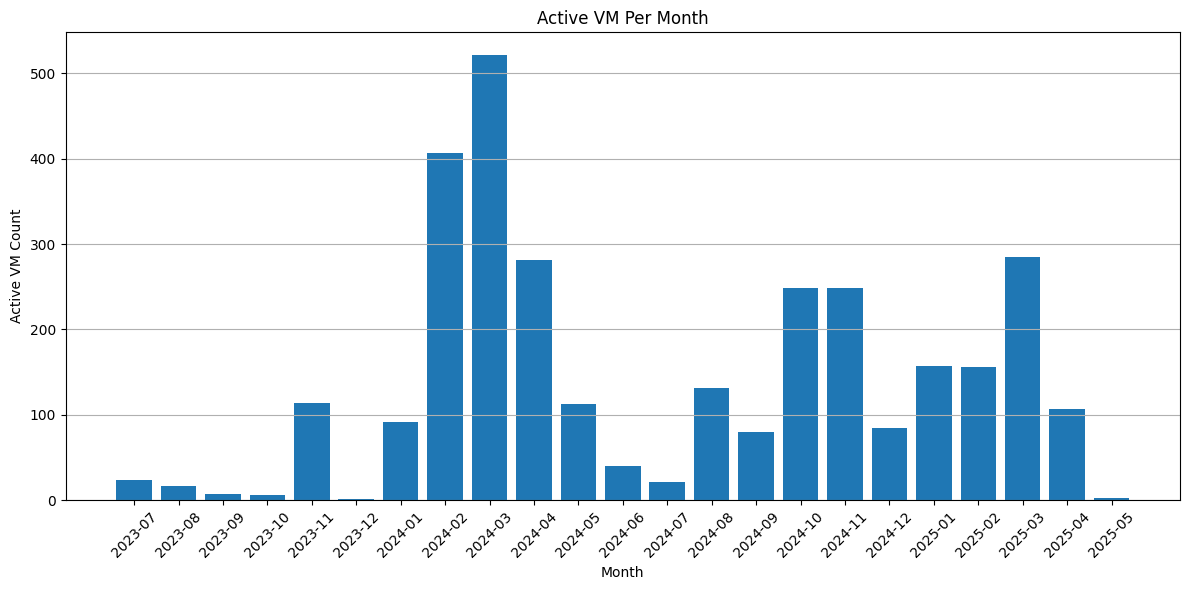

In [11]:
df = df_slivers_filtered
sliver_type_label = "_".join(sliver_types)

# Robust datetime parsing
df["lease_start"] = pd.to_datetime(df["lease_start"], format="mixed", utc=True, errors="coerce")
df["lease_end"] = pd.to_datetime(df["lease_end"], format="mixed", utc=True, errors="coerce")
df = df.dropna(subset=["lease_start", "lease_end"])

# Clamp lease times within query range
df["lease_start"] = df["lease_start"].clip(lower=query_start)
df["lease_end"] = df["lease_end"].clip(upper=query_end)

# Monthly range
start_month = df['lease_start'].min().to_period('M').to_timestamp()
end_month = df['lease_end'].max().to_period('M').to_timestamp()
month_range = pd.date_range(start=start_month, end=end_month, freq='MS')

active_counts = []
for month_start in month_range:
    month_start = month_start.tz_localize("UTC")
    month_end = (month_start + relativedelta(months=1)) - pd.Timedelta(seconds=1)
    active = df[(df["lease_start"] <= month_end) & (df["lease_end"] >= month_start)]
    active_counts.append(len(active))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(month_range.strftime('%Y-%m'), active_counts)
plt.xticks(rotation=45)
plt.title(f"Active {sliver_type_label} Per Month")
plt.xlabel("Month")
plt.ylabel(f"Active {sliver_type_label} Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Active Slivers per site per Month

/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_12318/1143919164.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lease_start"] = df["lease_start"].clip(lower=query_start)
/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_12318/1143919164.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lease_end"] = df["lease_end"].clip(upper=query_end)
/var/folders/11/k_bnqvpx04b89m0dvhx8ls1w0000gq/T/ipykernel_12318/1143919164.py:13: UserWarning: Converting to Period representation will 

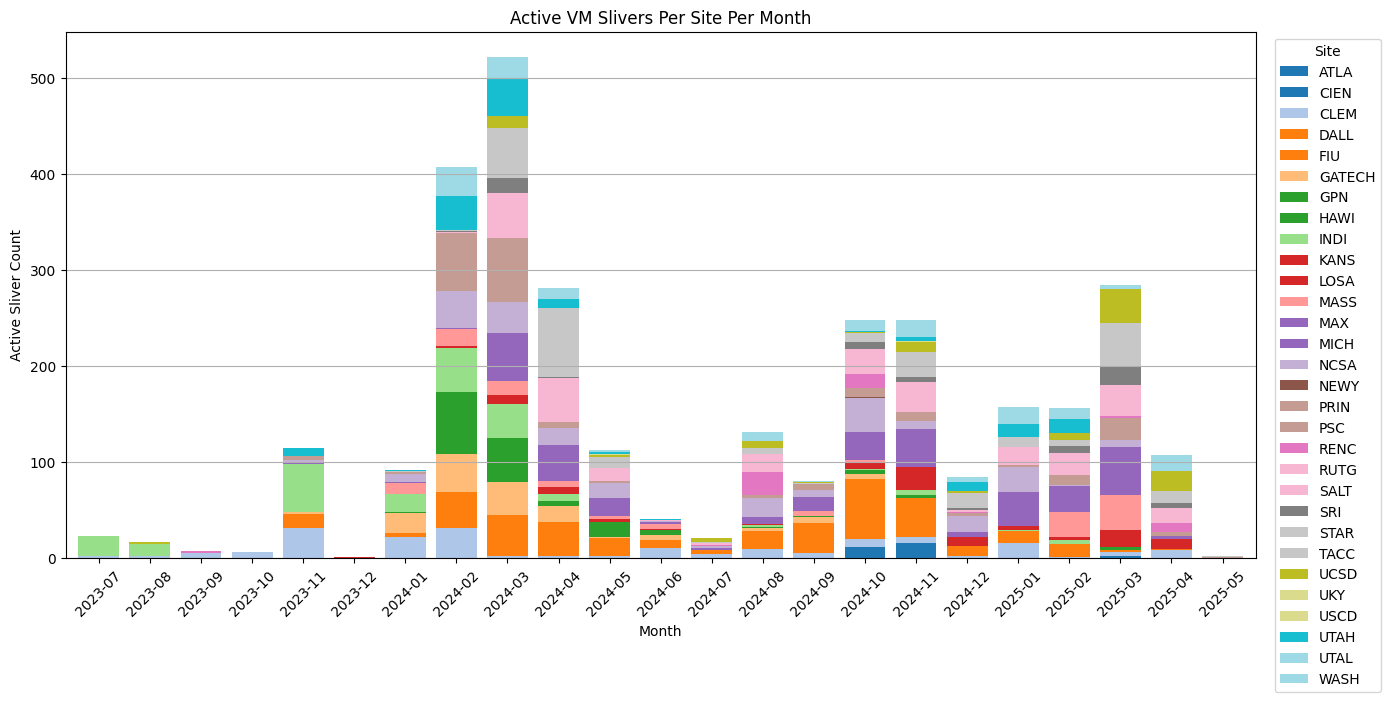

In [12]:
df = df_slivers_filtered
sliver_type_label = "_".join(sliver_types)

# Parse timestamps
df["lease_start"] = pd.to_datetime(df["lease_start"], format="mixed", utc=True, errors="coerce")
df["lease_end"] = pd.to_datetime(df["lease_end"], format="mixed", utc=True, errors="coerce")
df = df.dropna(subset=["lease_start", "lease_end", "site"])

df["lease_start"] = df["lease_start"].clip(lower=query_start)
df["lease_end"] = df["lease_end"].clip(upper=query_end)

# Create month range
start_month = df["lease_start"].min().to_period("M").to_timestamp()
end_month = df["lease_end"].max().to_period("M").to_timestamp()
month_range = pd.date_range(start=start_month, end=end_month, freq="MS")

# Initialize result DataFrame
site_names = sorted(df["site"].unique())
month_labels = month_range.strftime('%Y-%m')
usage = pd.DataFrame(0, index=month_labels, columns=site_names)

# Count active slivers per site per month
for month_start in month_range:
    month_label = month_start.strftime('%Y-%m')
    month_start = month_start.tz_localize("UTC")
    month_end = (month_start + relativedelta(months=1)) - pd.Timedelta(seconds=1)

    active = df[(df["lease_start"] <= month_end) & (df["lease_end"] >= month_start)]
    counts = active["site"].value_counts()
    for site, count in counts.items():
        usage.at[month_label, site] += count

# Plot stacked bar
plt.figure(figsize=(14, 7))
usage.plot(kind="bar", stacked=True, width=0.8, colormap="tab20", ax=plt.gca())
plt.title(f"Active {sliver_type_label} Slivers Per Site Per Month")
plt.xlabel("Month")
plt.ylabel("Active Sliver Count")
plt.xticks(rotation=45)
plt.legend(title="Site", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.tight_layout()
plt.grid(axis='y')
plt.show()